   yr  mnth  weekday  season  weathersit   temp  atemp    hum  windspeed  \
0   0     6        5       3           1  0.594  0.228  0.449      0.036   
1   1     1        3       4           4  0.891  0.382  0.877      0.409   
2   0     9        6       3           3  0.708  0.865  0.408      0.168   
3   0     1        4       1           3  0.592  0.180  0.201      0.287   
4   0     5        2       3           4  0.847  0.993  0.501      0.257   

   casual  registered   cnt  
0      47         572   619  
1     125        1569  1694  
2     238         773  1011  
3       6         707   713  
4     463         623  1086  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   yr          1000 non-null   int64  
 1   mnth        1000 non-null   int64  
 2   weekday     1000 non-null   int64  
 3   season      1000 non-null   int64  
 4   weathe

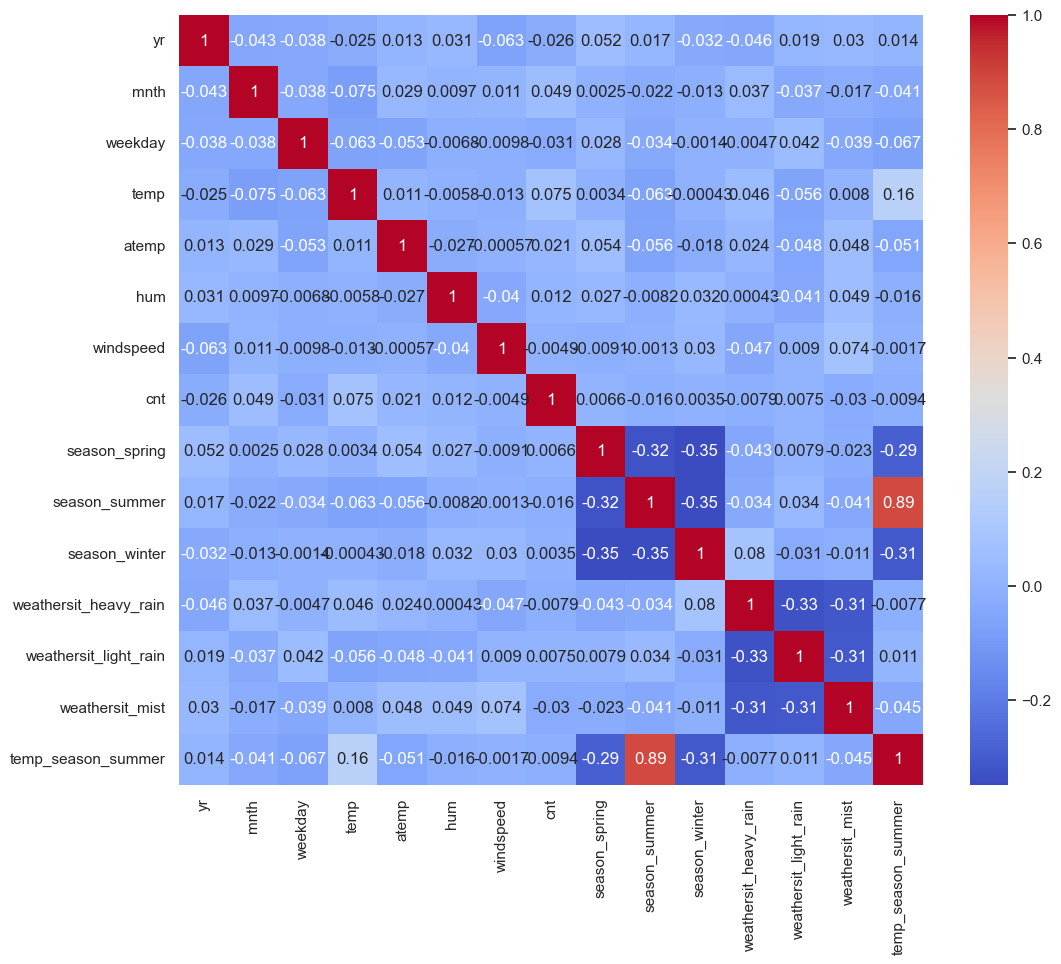

                 Features       VIF
0                      yr  1.015833
1                    mnth  1.015592
2                 weekday  1.018074
3                    temp  1.309119
4                   atemp  1.014219
5                     hum  1.011293
6               windspeed  1.014920
7           season_spring  1.546841
8           season_summer  6.632250
9           season_winter  1.574010
10  weathersit_heavy_rain  1.443841
11  weathersit_light_rain  1.431490
12        weathersit_mist  1.433797
13     temp_season_summer  6.168529
Selected Features: Index(['yr', 'temp', 'hum', 'windspeed', 'season_spring', 'season_summer',
       'weathersit_heavy_rain', 'weathersit_light_rain', 'weathersit_mist',
       'temp_season_summer'],
      dtype='object')
                       Coefficient
yr                      -17.921694
temp                    158.031100
hum                     -15.173196
windspeed               -44.238657
season_spring            16.459709
season_summer            71.

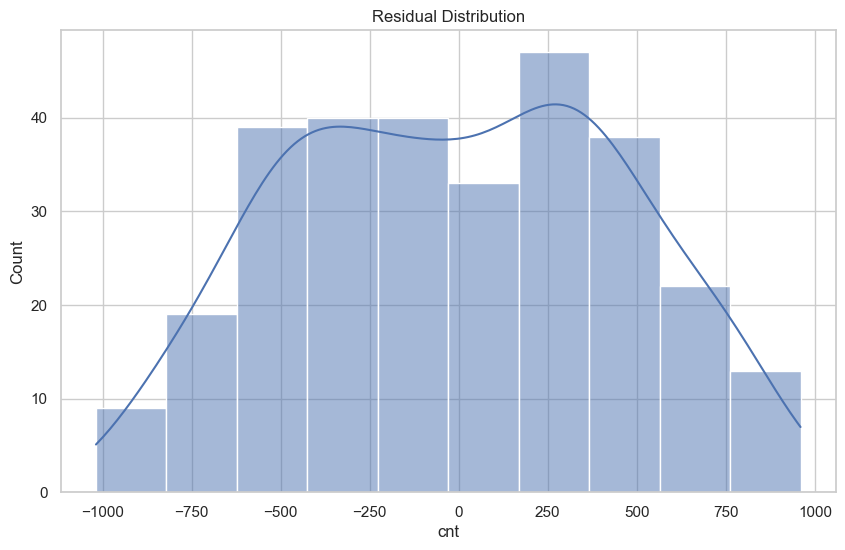

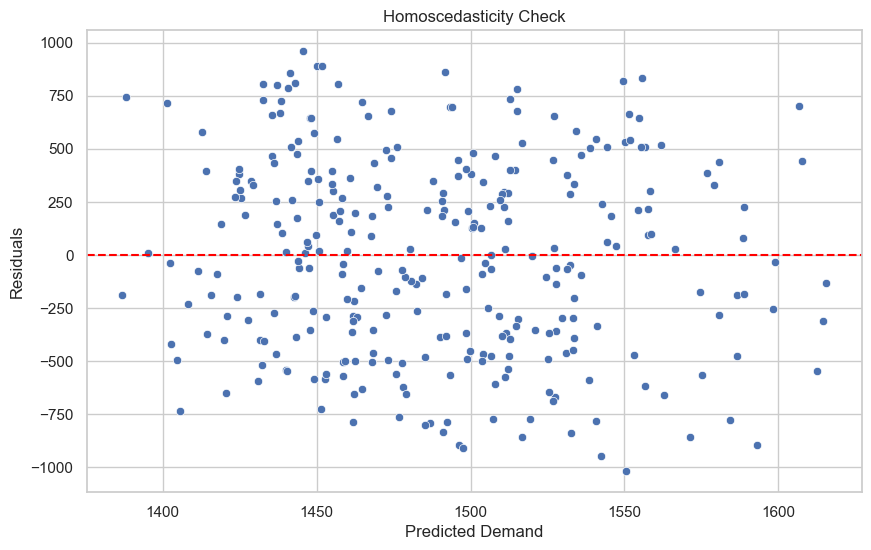

Best Ridge Alpha: 10.0
Ridge Regression R-squared Score: -0.006855094856438981
Final R-squared Score with Ridge: -0.0069


In [4]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm  # Importing statsmodels
from scipy.stats import zscore

# Set plot style
sns.set(style="whitegrid")

# Load the dataset
df = pd.read_csv('bike_sharing.csv')
print(df.head())

# Basic information about the dataset
print(df.info())

# Check for missing values
print(df.isnull().sum())

# Convert 'season' and 'weathersit' to categorical string values
df['season'] = df['season'].replace({1: 'spring', 2: 'summer', 3: 'fall', 4: 'winter'})
df['weathersit'] = df['weathersit'].replace({1: 'clear', 2: 'mist', 3: 'light_rain', 4: 'heavy_rain'})

# Convert categorical columns to dummy variables
df = pd.get_dummies(df, columns=['season', 'weathersit'], drop_first=True)

# Handle outliers using Z-score
df = df[(np.abs(zscore(df[['temp', 'atemp', 'hum', 'windspeed']])) < 3).all(axis=1)]

# Drop 'casual' and 'registered' columns as the target variable is 'cnt'
df.drop(['casual', 'registered'], axis=1, inplace=True)

# Add interaction terms
df['temp_season_summer'] = df['temp'] * df.get('season_summer', 0)

# Correlation matrix to check multicollinearity
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

# Split data into features and target
X = df.drop(['cnt'], axis=1)
y = df['cnt']

# Add constant for VIF calculation
X_with_const = sm.add_constant(X)

# Calculate VIF to check for multicollinearity
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X_with_const.values, i + 1) for i in range(len(X.columns))]
print(vif)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Recursive Feature Elimination (RFE) to select top features
model = LinearRegression()
rfe = RFE(model, n_features_to_select=10)
rfe.fit(X_train, y_train)
selected_features = X.columns[rfe.support_]
print("Selected Features:", selected_features)

# Train the Linear Regression model with selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]
model.fit(X_train_selected, y_train)

# Print model coefficients
coefficients = pd.DataFrame(model.coef_, X_train_selected.columns, columns=['Coefficient'])
print(coefficients)

# Predict on the test set
y_pred = model.predict(X_test_selected)

# Calculate R-squared score
r2 = r2_score(y_test, y_pred)
print(f"R-squared Score: {r2:.4f}")

# Perform cross-validation
cv_scores = cross_val_score(model, X_train_selected, y_train, cv=5, scoring='r2')
print("Cross-validated R-squared Score:", cv_scores.mean())

# Residual Analysis
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Residual Distribution')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Demand')
plt.ylabel('Residuals')
plt.title('Homoscedasticity Check')
plt.show()

# Ridge Regression for regularization
ridge = RidgeCV(alphas=[0.1, 1.0, 10.0], cv=5)
ridge.fit(X_train_selected, y_train)
print("Best Ridge Alpha:", ridge.alpha_)
print("Ridge Regression R-squared Score:", ridge.score(X_test_selected, y_test))

# Final model evaluation with Ridge Regression
y_pred_ridge = ridge.predict(X_test_selected)
final_r2 = r2_score(y_test, y_pred_ridge)
print(f"Final R-squared Score with Ridge: {final_r2:.4f}")
